In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

from src.phi import Phi
from src.definitions import Matrix, SparseMatrix
from src.helpers import get_FD_matrix, relative_error

In [2]:
# Set the desired theme
sns.set_theme(
    # style='whitegrid',
    font_scale=1.2,
)

# Read/build the matrices

In [3]:
orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

In [4]:
# TODO: Load from SuiteSparse
fd_1d = get_FD_matrix(n=4096, d=1)
fd_2d = get_FD_matrix(n=64, d=2)
fd_3d = get_FD_matrix(n=16, d=3)

# Evaluating the implemented Arnoldi algorithms

- Orthogonality error: $\left\| V_m^*V_m - I \right\|_{2}$
- Projection error: $\left\| V_m^* A V_m - H_m \right\|_{max}$

In [5]:
def check_arnoldi(A, v, ms: list = None, title: str = None):

    if not ms:
        ms = [int(m) for m in np.linspace(1, 100, 51)]

    data = {
        'm': [],
        'orthogonality': [],
        'projection': [],
        're-orthogonalization': [],
    }
    for m in ms:
        V_m, H_m = Phi.arnoldi(A=A, v=v, m=m, ro=True)
        data['m'].append(m)
        data['orthogonality'].append(np.linalg.norm(V_m.conjugate().T @ V_m - np.eye(m, dtype=A.dtype)))
        data['projection'].append(np.linalg.norm(V_m.conjugate().T @ A @ V_m - H_m))
        data['re-orthogonalization'].append(True)
        V_m, H_m = Phi.arnoldi(A=A, v=v, m=m, ro=False)
        data['m'].append(m)
        data['orthogonality'].append(np.linalg.norm(V_m.conjugate().T @ V_m - np.eye(m, dtype=A.dtype)))
        data['projection'].append(np.linalg.norm(V_m.conjugate().T @ A @ V_m - H_m))
        data['re-orthogonalization'].append(False)

    # Plot the errors
    plt.figure()
    fig, axs = plt.subplots(2, figsize=(8,8))
    sns.lineplot(
        data=data,
        x='m',
        y='orthogonality',
        hue='re-orthogonalization',
        ax=axs[0],
    )
    axs[0].set(
        ylabel='Orthogonality error $\left\| V_m^* V_m - I_m \\right\|$',
        yscale='log',
        # xlabel='Dimension of the Krylov subspace $m$',
    )
    sns.lineplot(
        data=data,
        x='m',
        y='projection',
        hue='re-orthogonalization',
        ax=axs[1],
    )
    axs[1].set(
        ylabel='Projection error $\left\| V_m^* A V_m - H_m \\right\|$',
        yscale='log',
        xlabel='Dimension of the Krylov subspace $m$',
    )

    if title:
        fig.suptitle(title)


## Random dense mtrix

In [ ]:
n = 1000
check_arnoldi(
    A=np.random.random_sample(size=(n, n)).astype(np.float64),
    v=np.ones(shape=(n,), dtype=np.float64),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title=f'Accuracy of the Arnoldi method for a random dense {n}$\\times${n} matrix',
)

## `fd_1d`

In [7]:
check_arnoldi(
    A=fd_1d,
    v=np.ones(shape=(fd_1d.shape[0],), dtype=fd_1d.dtype),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $fd\_1d$',
)

KeyboardInterrupt: 

## `fd_2d`

<Figure size 640x480 with 0 Axes>

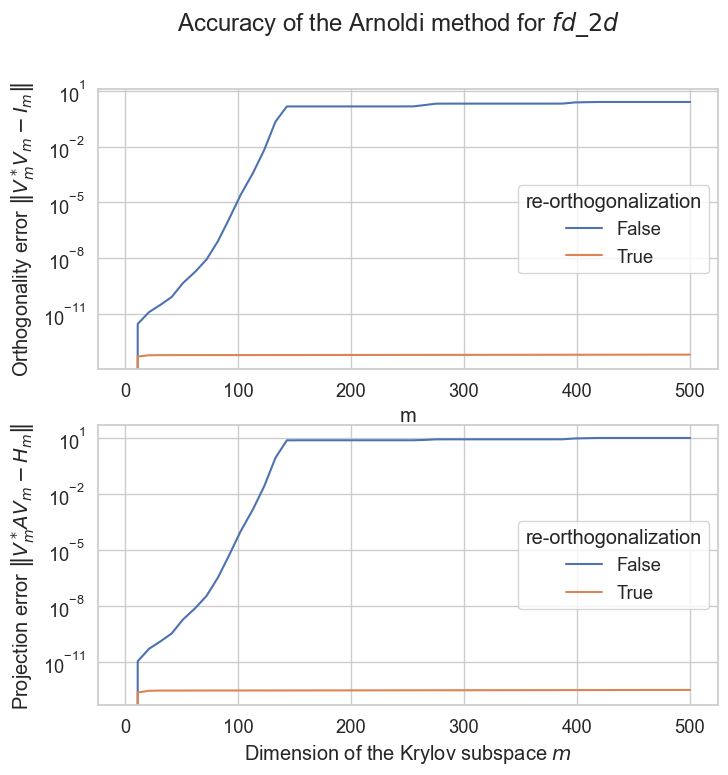

In [8]:
check_arnoldi(
    A=fd_2d,
    v=np.ones(shape=(fd_2d.shape[0],), dtype=fd_2d.dtype),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $fd\_2d$',
)

## `fd_3d`

<Figure size 640x480 with 0 Axes>

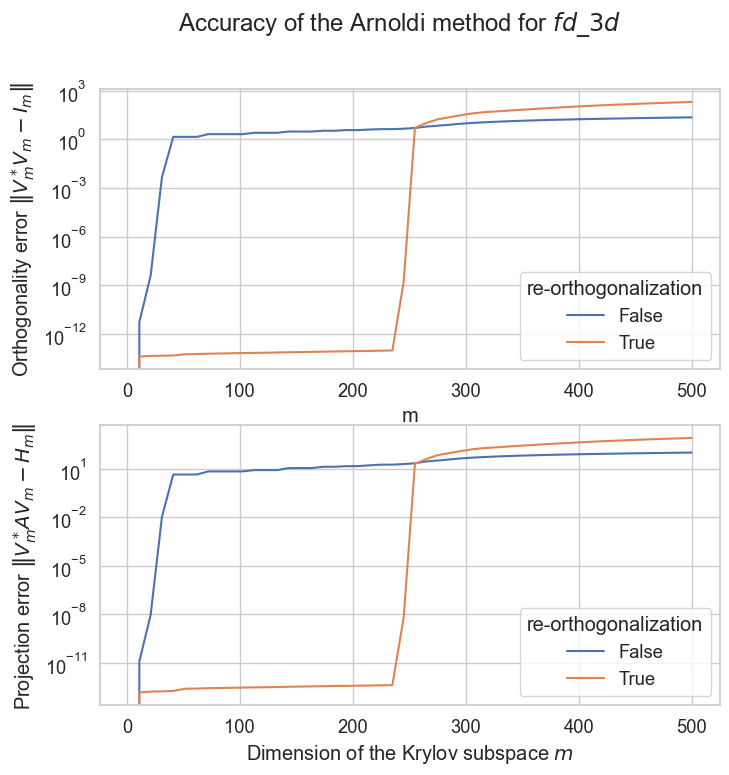

In [9]:
check_arnoldi(
    A=fd_3d,
    v=np.ones(shape=(fd_3d.shape[0],), dtype=fd_3d.dtype),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $fd\_3d$',
)

## `orani678`

In [8]:
check_arnoldi(
    A=orani678,
    v=np.ones(shape=(orani678.shape[0],), dtype=orani678.dtype),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $orani678$',
)

KeyboardInterrupt: 

## `bcspwr10`

<Figure size 640x480 with 0 Axes>

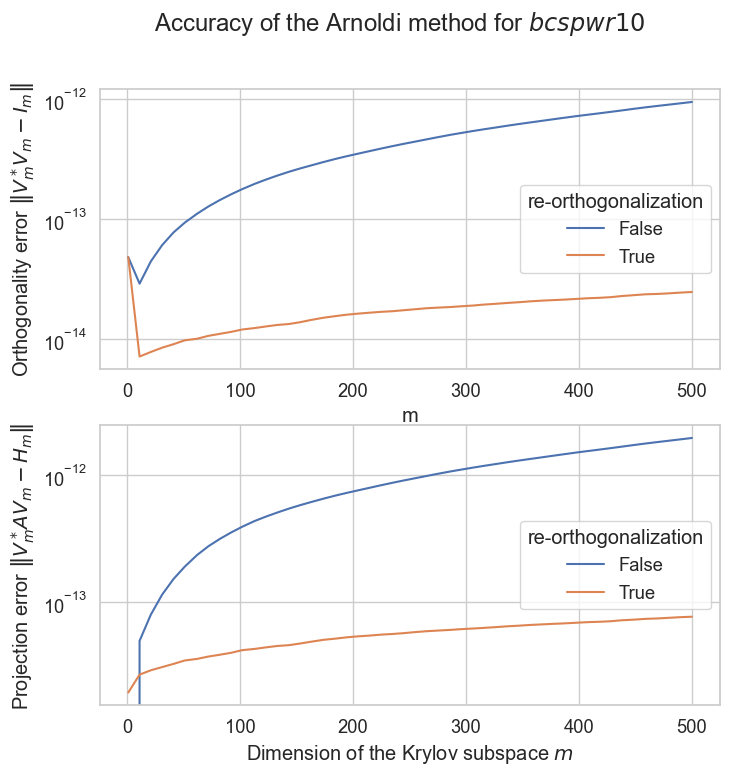

In [11]:
check_arnoldi(
    A=bcspwr10,
    v=np.array([1, 0] * (bcspwr10.shape[0] // 2)),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $bcspwr10$',
)

## `gr_30_30`

<Figure size 640x480 with 0 Axes>

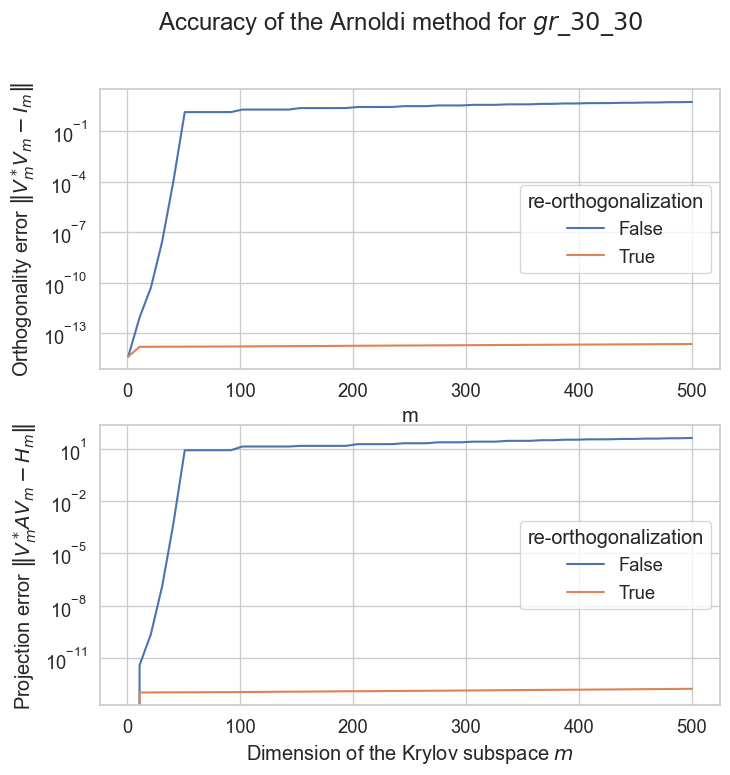

In [12]:
check_arnoldi(
    A=gr_30_30,
    v=np.ones(shape=(gr_30_30.shape[0],), dtype=gr_30_30.dtype),
    ms = [int(m) for m in np.linspace(1, 500, 50)],
    title='Accuracy of the Arnoldi method for $gr\_30\_30$',
)

## `helm2d03`

<Figure size 640x480 with 0 Axes>

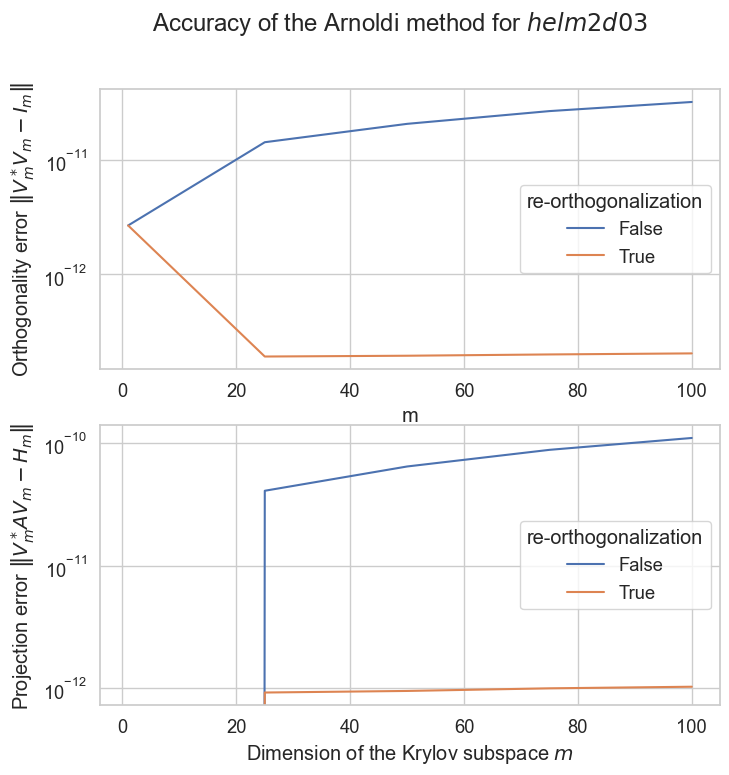

In [13]:
check_arnoldi(
    A=helm2d03,
    v=np.ones(shape=(helm2d03.shape[0],), dtype=helm2d03.dtype),
    ms = [int(m) for m in np.linspace(1, 100, 5)],
    title='Accuracy of the Arnoldi method for $helm2d03$',
)

# $\varphi$-function approximation

In [30]:
def study_convergence(
        A: SparseMatrix, v: np.ndarray,
        p_max: int = 5, ms: list = None,
        title: str = None,
        m_exact: int = None,
) -> None:
    dfs = []
    for p in range(p_max):
        # Create the phi-function
        phi = Phi(p=p)

        # Get the true evaluation
        if not m_exact:
            exact = phi.recursive(A=A, v=v)
        else:
            exact = phi.krylovsubspace(A=A, v=v, m=m_exact)

        # get the Krylov subspace method approximation
        if not ms:
            ms = [int(m) for m in np.linspace(1, 100, 51)]
        errs = []
        for m in ms:
            krylov = phi.krylovsubspace(A=A, v=v, m=m)
            errs.append(relative_error(approximation=krylov, exact=exact))

        dfs.append(
            pd.DataFrame({
                '$p$': [p] * len(ms),
                '$m$': ms,
                'Relative error': errs,
            })
        )

    # Plot the errors
    data = pd.concat(objs=dfs, axis=0)
    sns.relplot(
        data=data,
        x='$m$',
        y='Relative error',
        hue='$p$',
        kind='line',
        height=5,
        aspect=1.5,
    )
    plt.yscale('log')
    plt.ylim([1e-16, 1e+01])
    if title:
        plt.title(title)
    plt.xlabel('Dimension of the Krylov subspace ($m$)')
    plt.ylabel('Relative error of $\\varphi_p(A)v$')

    return data

## Random sparse matrix

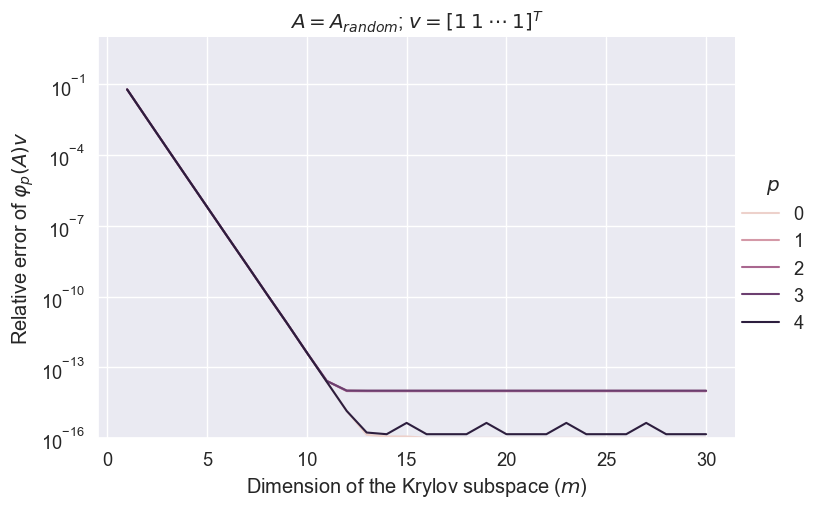

In [31]:
n = 3712
A_random = sps.rand(n, n, dtype=np.float64, format='csc', density=.1)
df_random = study_convergence(
    A=A_random,
    v=np.ones(shape=(A_random.shape[0],), dtype=A_random.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{random}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_random['$A =$'] = '$A_{random}$'

## `fd_1d`

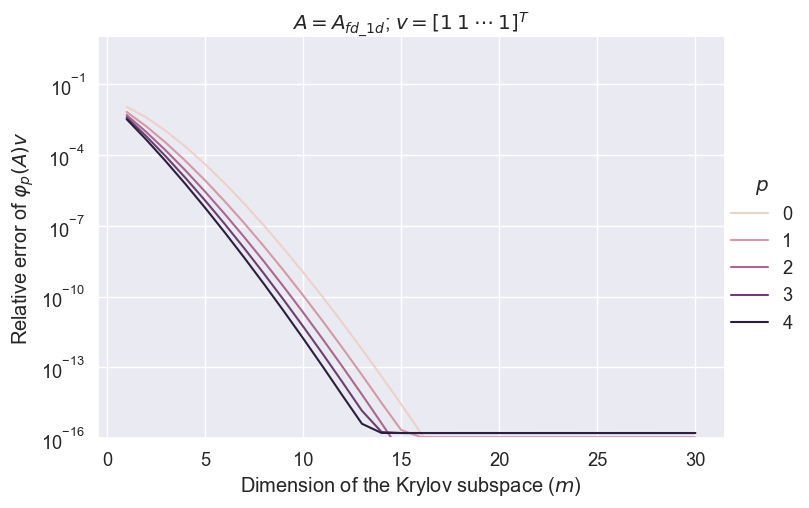

In [55]:
df_fd_1d = study_convergence(
    A=fd_1d,
    v=np.ones(shape=(fd_1d.shape[0],), dtype=fd_1d.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{fd\_1d}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_fd_1d['$A =$'] = '$fd\_1d$'

## `fd_2d`

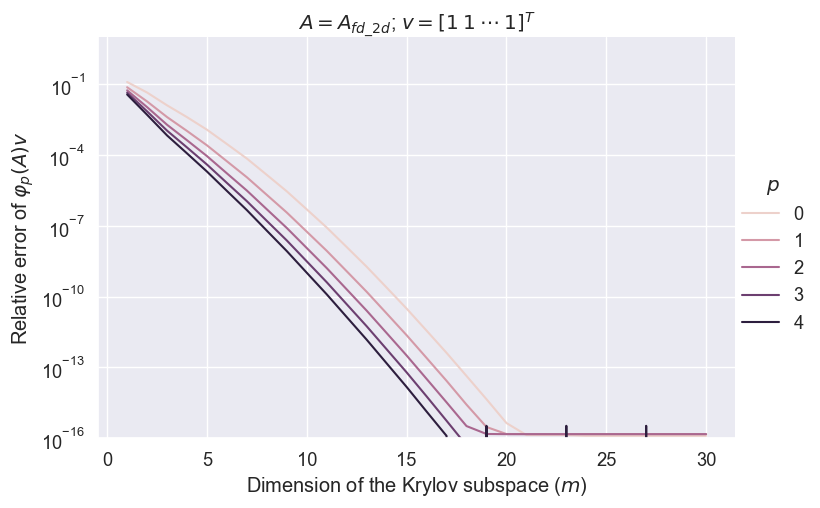

In [33]:
df_fd_2d = study_convergence(
    A=fd_2d,
    v=np.ones(shape=(fd_2d.shape[0],), dtype=fd_2d.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{fd\_2d}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_fd_2d['$A =$'] = '$fd\_2d$'

## `fd_3d`

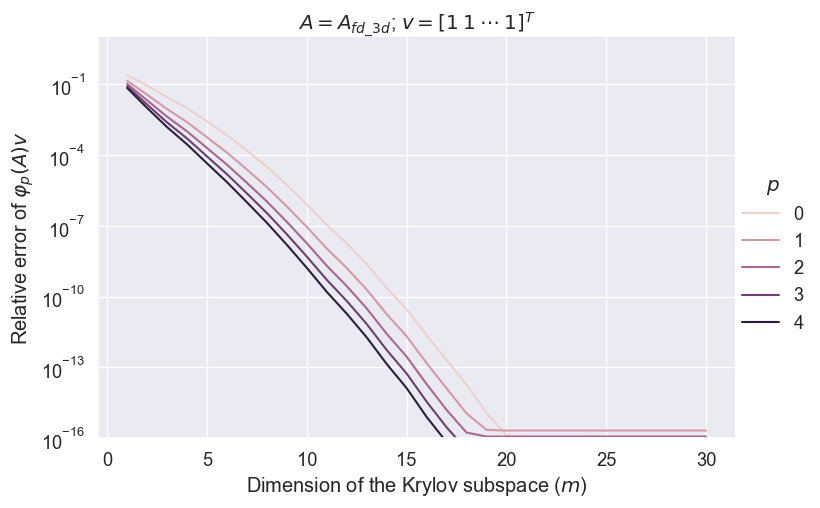

In [57]:
df_fd_3d = study_convergence(
    A=fd_3d,
    v=np.ones(shape=(fd_3d.shape[0],), dtype=fd_3d.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{fd\_3d}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_fd_3d['$A =$'] = '$fd\_3d$'

## [`orani678`](https://suitesparse-collection-website.herokuapp.com/?filterrific%5Bsearch_query%5D=orani678&filterrific%5Bsorted_by%5D=name_asc) (unsymmetric)

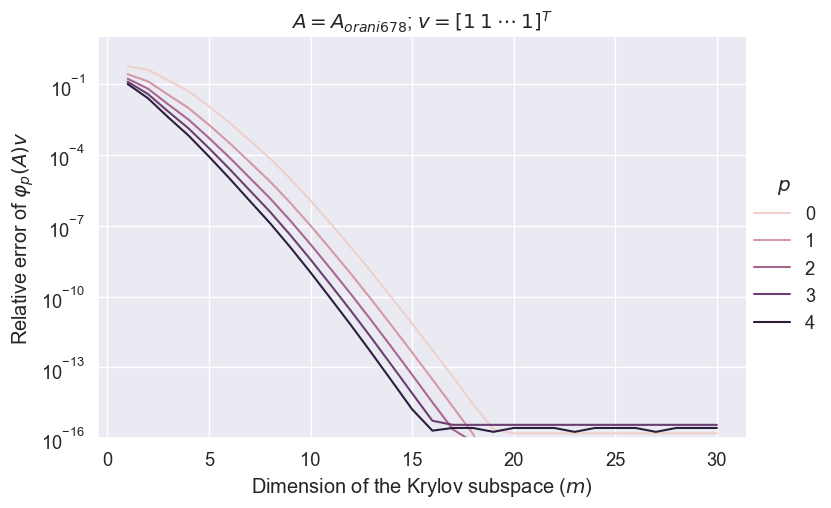

In [35]:
df_orani678 = study_convergence(
    A=orani678,
    v=np.ones(shape=(orani678.shape[0],), dtype=orani678.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{orani678}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_orani678['$A =$'] = '$orani678$'

## [`bcspwr10`](https://suitesparse-collection-website.herokuapp.com/?filterrific%5Bsearch_query%5D=bcspwr10&filterrific%5Bsorted_by%5D=name_asc) (Hermitian, SINGULAR)

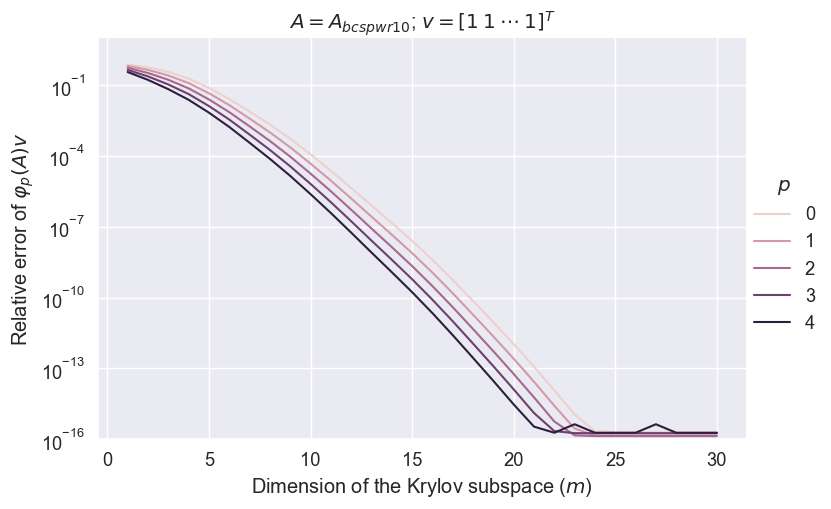

In [36]:
df_bcspwr10 = study_convergence(
    A=bcspwr10,
    v=np.ones(shape=(bcspwr10.shape[0],), dtype=bcspwr10.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{bcspwr10}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_bcspwr10['$A =$'] = '$bcspwr10$'

## [`gr_30_30`](https://suitesparse-collection-website.herokuapp.com/HB/gr_30_30) (symmetric)

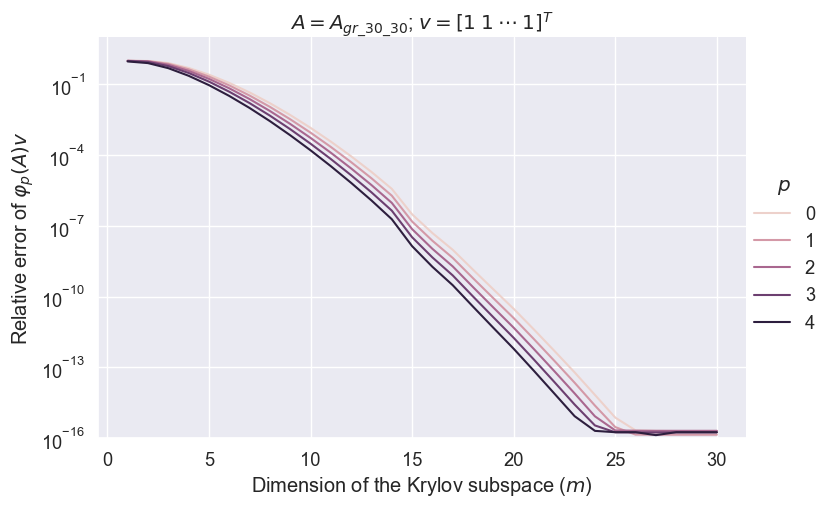

In [58]:
df_gr_30_30 = study_convergence(
    A=gr_30_30,
    v=np.ones(shape=(gr_30_30.shape[0],), dtype=gr_30_30.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{gr\_30\_30}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_gr_30_30['$A =$'] = '$gr\_30\_30$'

## [`helm2d03`](https://suitesparse-collection-website.herokuapp.com/GHS_indef/helm2d03) (symmetric)

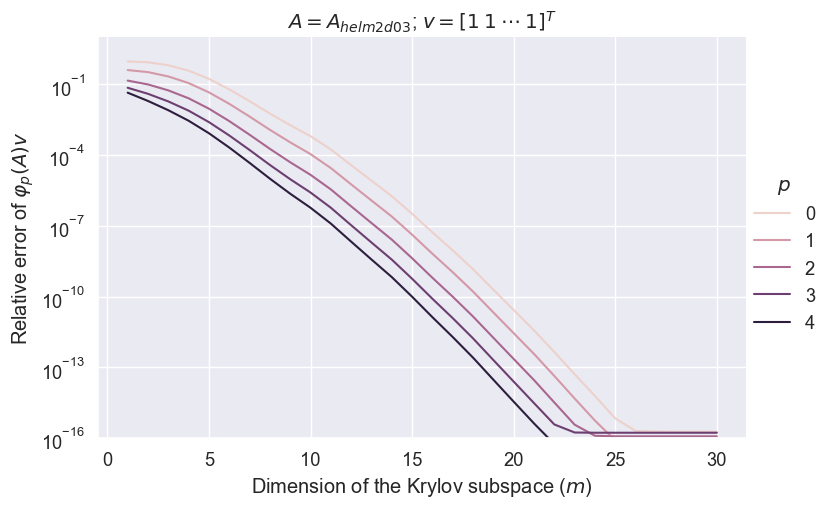

In [59]:
df_helm2d03 = study_convergence(
    A=helm2d03,
    v=np.ones(shape=(helm2d03.shape[0],), dtype=helm2d03.dtype),
    p_max=5,
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    title='$A=A_{helm2d03}$; $v=[1\:1\:\cdots\:1]^T$',
    m_exact=256,
)
df_helm2d03['$A =$'] = '$helm2d03$'

# Comparing convergence of matrices

## Compare matrices with different spectrums

In [26]:
def compare_convergences(dfs: list[pd.DataFrame], ps: list[int], title: str = None):
    g = sns.FacetGrid(
        data=pd.concat([pd.concat([df[df['$p$'] == p] for p in ps]) for df in dfs]),
        col='$p$',
        hue='$A =$',
        col_wrap=2,
        height=5,
        aspect=1.5,
    )
    g.map(sns.lineplot, '$m$', 'Relative error')
    g.add_legend()
    g.set(yscale='log', ylim=[1e-16, 1e+01])
    if title:
        plt.title(title)
    return g

In [27]:
def get_errors_taylor(ps, n=2000, alpha=8):
    """
    Assumes the vector v is ones of size n.
    """

    ms = np.linspace(1, 30, 30, dtype=np.int64)
    dfs = []
    for p in ps:
        bound = (2 * np.sqrt(n) * (alpha ** ms)
                / np.array([np.math.factorial(m + p) for m in ms], dtype=np.float64))

        dfs.append(
            pd.DataFrame({
                '$p$': [p] * len(ms),
                '$m$': ms,
                '$A =$': 'Estimate #1',
                'Relative error': bound,
            })
        )

    return pd.concat(dfs)

In [28]:
def get_errors_chebyshev(ps, n=2000, alpha=8):
    """
    Assumes the vector v is ones of size n.
    estimates for p!=1 are not valid.
    """
    ms = np.linspace(1, 30, 30, dtype=np.int64)
    dfs = []
    for p in ps:
        bound_i = (
            np.sqrt(n) * (5 * (alpha ** 2)) / (ms ** 3)
            * np.exp(- 4 * (ms ** 2) / (5 * alpha))
        )
        bound = (
            np.sqrt(n) * 64 / (12 * ms - 5 * alpha)
            * ((np.e * alpha / (4 * ms + 2 * alpha)) ** ms)
        )
        bound[np.where(ms < (alpha / 2))] = bound_i[np.where(ms < (alpha / 2))]
        # bound[np.where(ms < np.sqrt(alpha))] = np.nan

        dfs.append(
            pd.DataFrame({
                '$p$': [p] * len(ms),
                '$m$': ms,
                '$A =$': 'Estimate #2',
                'Relative error': bound,
            })
        )

    return pd.concat(dfs)

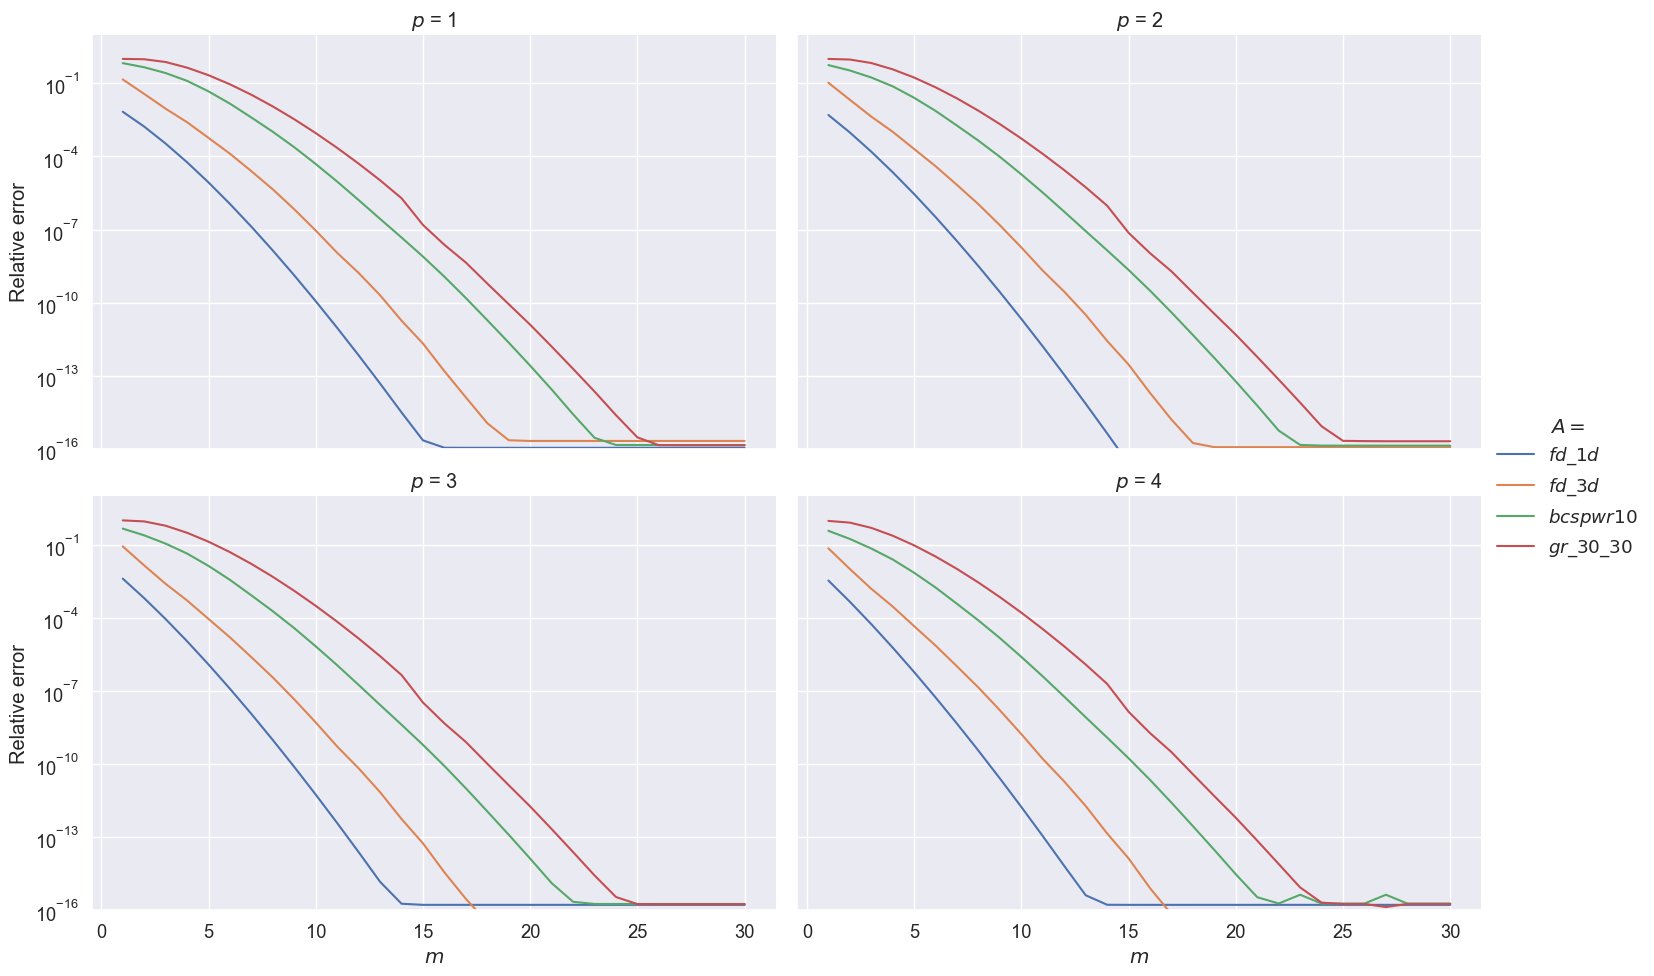

In [29]:
ps=[1, 2, 3, 4]
g = compare_convergences(
    dfs=[
        df_fd_1d,
        df_fd_3d,
        df_bcspwr10,
        df_gr_30_30,
    ],
    ps=ps,
)

## Compare with error estimations

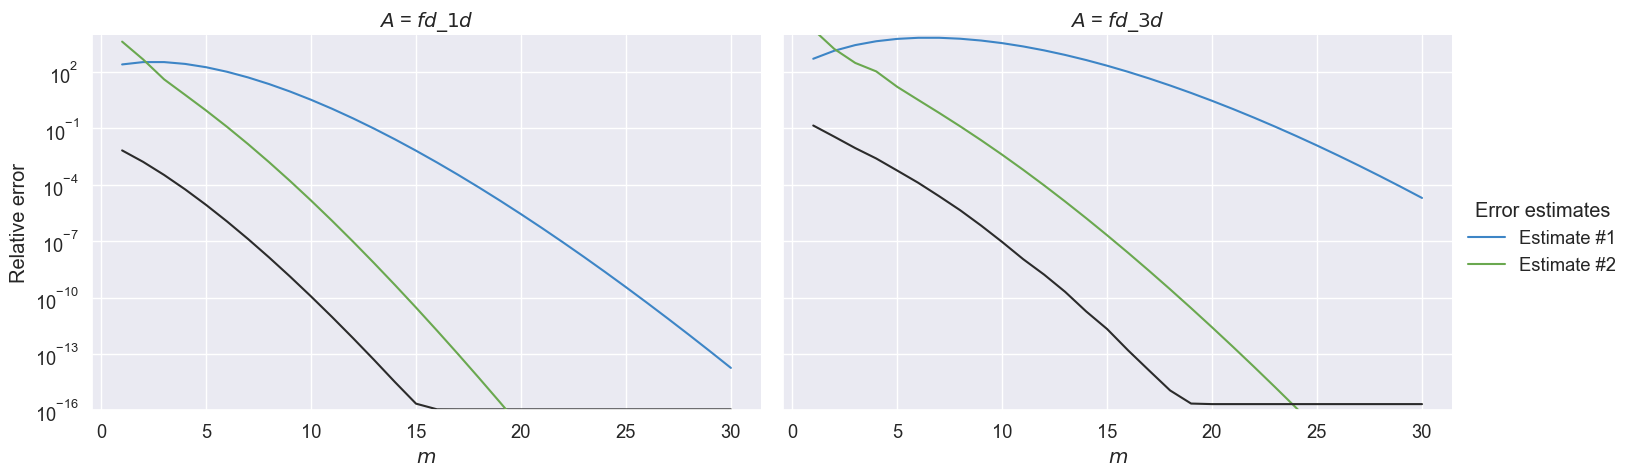

In [25]:
n = fd_1d.shape[0]
ps = [1]
df1 = pd.concat([
    df_fd_1d[df_fd_1d['$p$'] == 1].copy(),
    get_errors_taylor(ps=ps, n=n, alpha=4),
    get_errors_chebyshev(ps=ps, n=n, alpha=4)
])
df2 = pd.concat([
    df_fd_3d[df_fd_3d['$p$'] == 1].copy(),
    get_errors_taylor(ps=ps, n=n, alpha=8.01),
    get_errors_chebyshev(ps=ps, n=n, alpha=8)
])
df1['$A$'] = '$fd\_1d$'
df2['$A$'] = '$fd\_3d$'
g = sns.FacetGrid(
    data=pd.concat([df1, df2]),
    col='$A$',
    hue='$A =$',
    col_wrap=2,
    height=5,
    aspect=1.5,
    palette=['#2b2b2b', '#3d85c6', '#6aa84f'],
)
g.map(sns.lineplot, '$m$', 'Relative error')
g.add_legend(
    label_order=['Estimate #1', 'Estimate #2'],
    title='Error estimates',
    loc='right',
)
g.set(yscale='log', ylim=[1e-16, 1e+04])

# Study the effect of re-orthogonalization

In [49]:
def study_convergence_with_ro(
        A: SparseMatrix, v: np.ndarray,
        ps: list[int] = [1], ms: list = None,
        title: str = None,
        m_exact: int = None,
) -> None:
    dfs = []
    for p in ps:
        # Create the phi-function
        phi = Phi(p=p)

        # Get the true evaluation
        if not m_exact:
            exact = phi.recursive(A=A, v=v)
        else:
            exact = phi.krylovsubspace(A=A, v=v, m=m_exact, ro=True)

        # get the Krylov subspace method approximation
        if not ms:
            ms = [int(m) for m in np.linspace(1, 100, 51)]

        for ro in [True, False]:
            errs = []
            for m in ms:
                krylov = phi.krylovsubspace(A=A, v=v, m=m, ro=ro)
                errs.append(relative_error(approximation=krylov, exact=exact))
            dfs.append(
                pd.DataFrame({
                    '$p$': [p] * len(ms),
                    '$m$': ms,
                    'Relative error': errs,
                    'Re-orthogonalization': ro,
                })
            )

    # Plot the errors
    data = pd.concat(objs=dfs, axis=0)
    sns.relplot(
        data=data,
        x='$m$',
        y='Relative error',
        hue='Re-orthogonalization',
        col='$p$',
        col_wrap=2,
        kind='line',
        height=5,
        aspect=1.5,
    )
    plt.yscale('log')
    plt.ylim([1e-16, 1e+01])

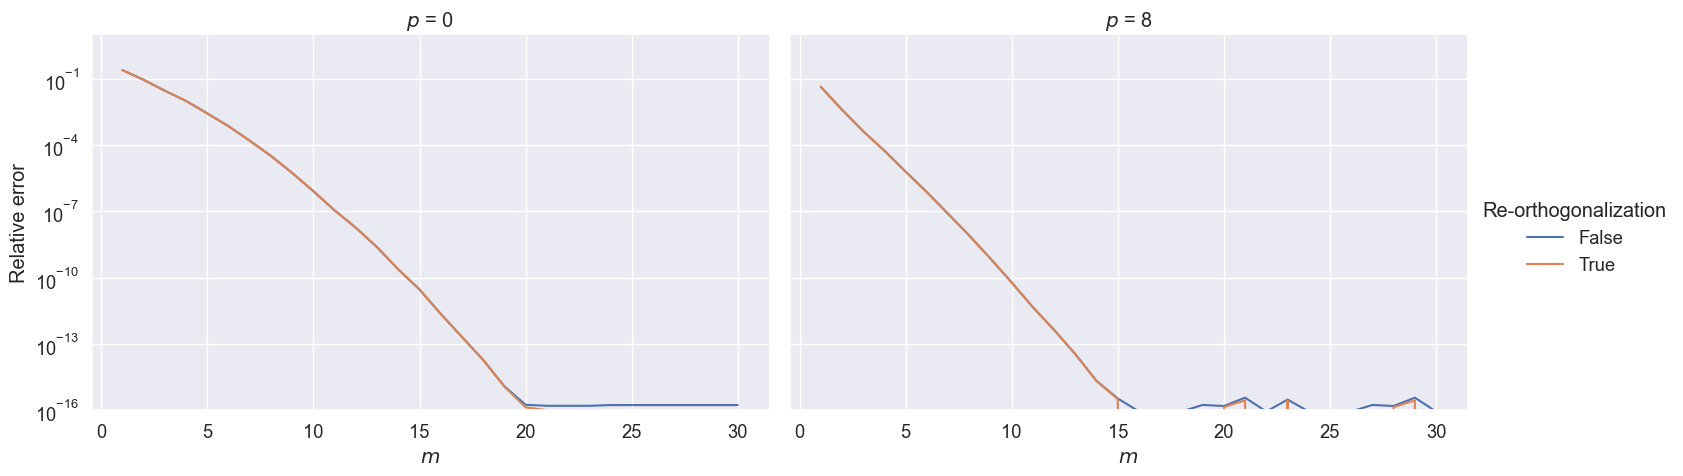

In [51]:
study_convergence_with_ro(
    A=fd_3d,
    v=np.ones(shape=(fd_3d.shape[0],), dtype=fd_3d.dtype),
    ps=[0, 8],
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    m_exact=256,
)

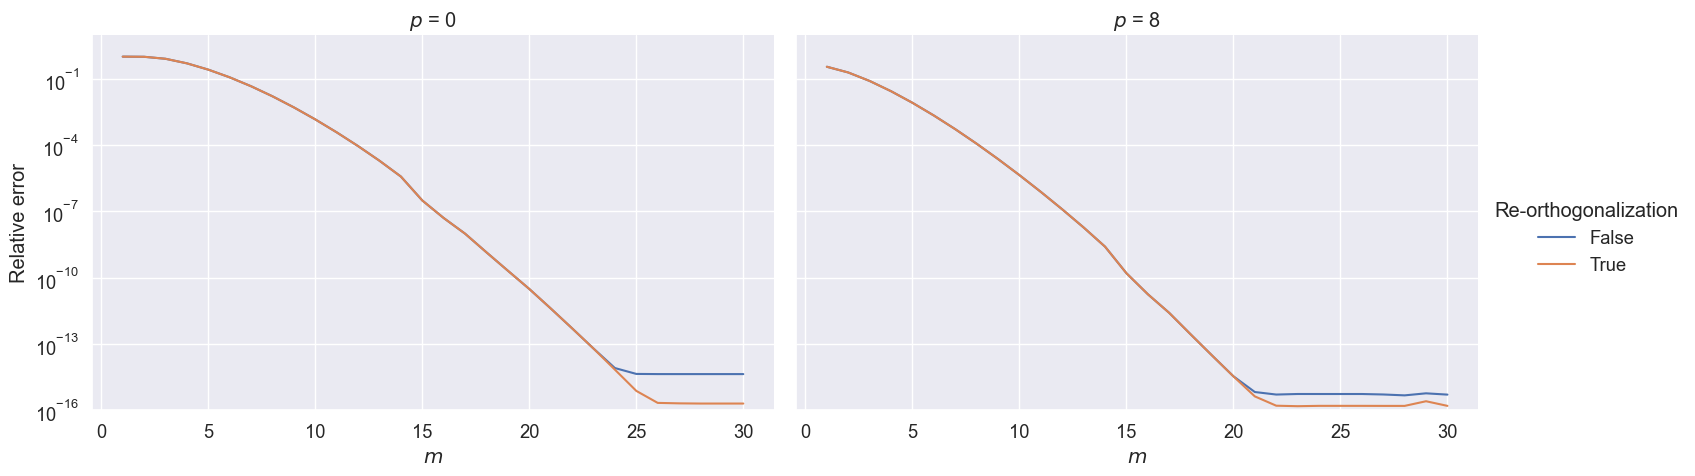

In [50]:
study_convergence_with_ro(
    A=gr_30_30,
    v=np.ones(shape=(gr_30_30.shape[0],), dtype=gr_30_30.dtype),
    ps=[0, 8],
    ms=[int(m) for m in np.linspace(1, 30, 30)],
    m_exact=256,
)